# GRO Redemption Stats

### Libs & Dataset

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_txns = pd.read_csv('../data/out/gro_redemption_txns.csv')
df_txns.head(2)

,Txhash,Blockno,UnixTimestamp,DateTime (UTC),From,To,TokenValue,USDValueDayOfTx,ContractAddress,TokenName,TokenSymbol,Address,UserType
0,0x233bed8746971ffbeb34bef48a8ad84dd33bd030465f...,18229361,1695845099,2023-09-27 20:04:59,0x859df1b9bb101715b7c9bfc213378e383d216241,0x204d9de758217a39149767731a87bcc32427b6ef,1000.000000,$290.15,0x3ec8798b81485a254928b70cda1cf0a2bb0b74d7,Gro DAO Token,GRO,0x859df1b9bb101715b7c9bfc213378e383d216241,Team
1,0xe4c282ac2f79c790ef09dfa7487577f48ce6f14a7379...,18229833,1695850799,2023-09-27 21:39:59,0x01ab07010c2f4bf5971537669cc19d5d8cf320a0,0x204d9de758217a39149767731a87bcc32427b6ef,60.186427,$17.46,0x3ec8798b81485a254928b70cda1cf0a2bb0b74d7,Gro DAO Token,GRO,0x01ab07010c2f4bf5971537669cc19d5d8cf320a0,Community


In [61]:
df_txns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Txhash           314 non-null    object 
 1   Blockno          314 non-null    int64  
 2   UnixTimestamp    314 non-null    int64  
 3   DateTime (UTC)   314 non-null    object 
 4   From             314 non-null    object 
 5   To               314 non-null    object 
 6   TokenValue       314 non-null    float64
 7   USDValueDayOfTx  236 non-null    object 
 8   ContractAddress  314 non-null    object 
 9   TokenName        314 non-null    object 
 10  TokenSymbol      314 non-null    object 
 11  Address          314 non-null    object 
 12  UserType         314 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 32.0+ KB


### Data transformations

In [62]:
# Convert date string to datetime
df_txns["DateTime (UTC)"] = pd.to_datetime(df_txns["DateTime (UTC)"])

# Add hour
df_txns["Hour"] = df_txns["DateTime (UTC)"].dt.hour

# Add day of the week
dmap = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
df_txns["dow_num"] = df_txns["DateTime (UTC)"].dt.dayofweek
df_txns["dow"] = df_txns["dow_num"].apply(lambda x: dmap[x])

# Get only deposits
df_txns = df_txns[df_txns["TokenValue"] > 0]

### Function to show bar plots

In [63]:
def set_texts(xlabel: str, ylabel: str):
    """
    Return the title, x label, and y label, with the title formatting based on two parameters
    """
    return f"{ylabel} per {xlabel}", xlabel, ylabel


def show_bar_plot(aggr: str):
    """
    Draw bar chart with different aggregations based on the `aggr` parameter
    """
    if aggr == "count_deposit_x_hour":
        df = df_txns.groupby("Hour")["TokenValue"].count()
        title, xlabel, ylabel = set_texts("Hour of the day", "Num. Deposits")
    elif aggr == "sum_gro_x_hour":
        df = df_txns.groupby("Hour")["TokenValue"].sum()
        title, xlabel, ylabel = set_texts("Hour of the day", "GRO deposited")
    elif aggr == "count_deposit_x_dow":
        # Perform groupby and count, then reset the index to convert it into a DataFrame
        df = df_txns.groupby(["dow", "dow_num"])["TokenValue"].count().reset_index()
        # Sort by 'dow_num', drop the 'dow_num' column, and set 'dow' as the new index
        df = df.sort_values("dow_num").drop("dow_num", axis=1).set_index("dow")
        title, xlabel, ylabel = set_texts("Day of the week", "Num. Deposits")
    elif aggr == "sum_gro_x_dow":
        df = df_txns.groupby(["dow", "dow_num"])["TokenValue"].sum().reset_index()
        df = df.sort_values("dow_num").drop("dow_num", axis=1).set_index("dow")
        title, xlabel, ylabel = set_texts("Day of the week", "GRO deposited")
    elif aggr == "sum_gro_x_day":
        df = df_txns.groupby(df_txns["DateTime (UTC)"].dt.date)["TokenValue"].sum()
        title, xlabel, ylabel = set_texts("Day", "GRO deposited")
    else:
        print(f"aggregator {aggr} not found in function show_bar_plot()")
        return

    plt.figure(figsize=(15, 6))
    ax = df.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend().remove()

    if aggr == "count_deposit_x_hour" or aggr == "sum_gro_x_hour":
        hour_labels = [f"{hour:02d}:00" for hour in range(24)]
        ax.set_xticklabels(hour_labels, rotation=90, fontsize=10)

    for bar in ax.patches:
        height = bar.get_height()
        if (
            aggr == "sum_gro_x_hour"
            or aggr == "sum_gro_x_dow"
            or aggr == "sum_gro_x_day"
        ):
            label = f"{height / 1_000_000:.2f}M"  # Convert to millions and append 'M'
        else:
            label = f"{height:.0f}"

        plt.annotate(
            label,
            (bar.get_x() + bar.get_width() / 2, height),
            ha="center",
            va="center",
            size=8,
            xytext=(0, 8),
            textcoords="offset points",
        )

    plt.show()

### Visuals

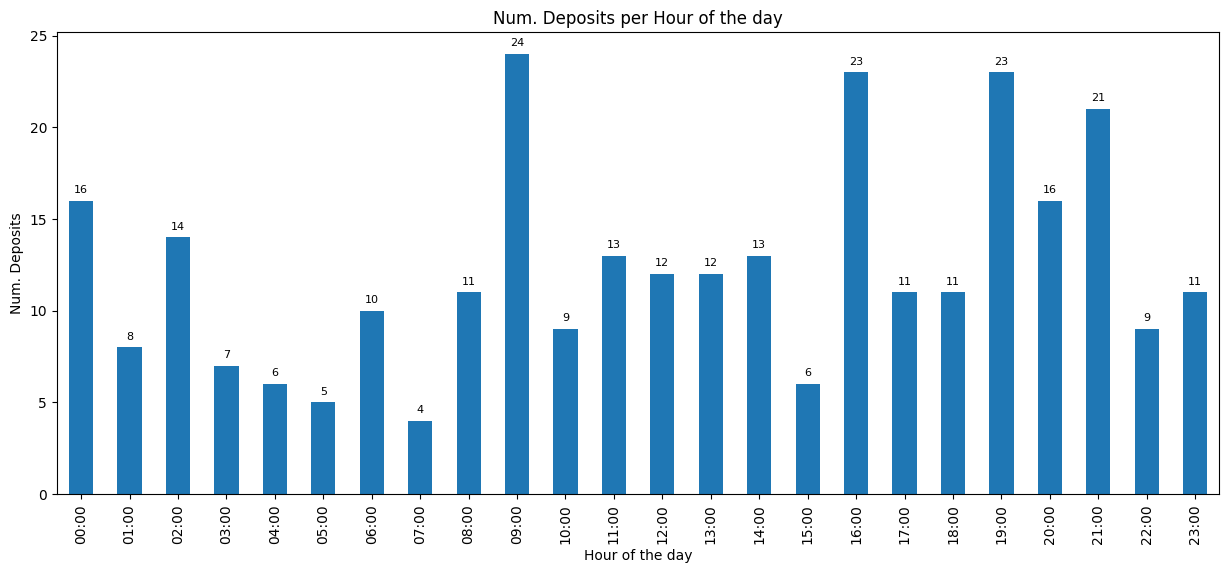

In [64]:
show_bar_plot(aggr="count_deposit_x_hour")

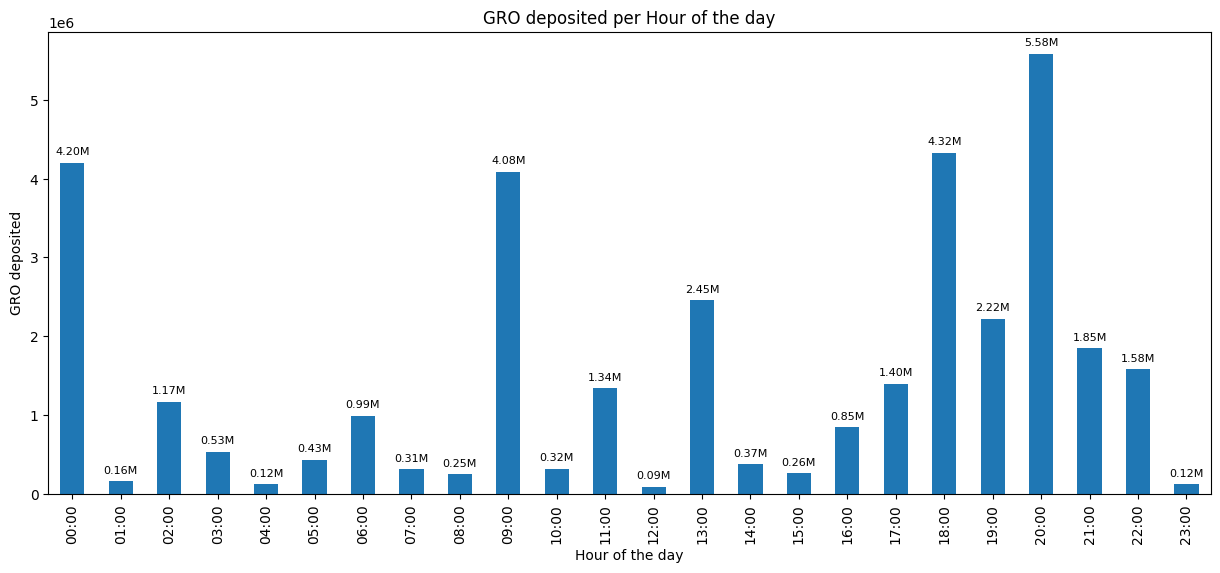

In [65]:
show_bar_plot(aggr="sum_gro_x_hour")

<Figure size 1500x600 with 0 Axes>

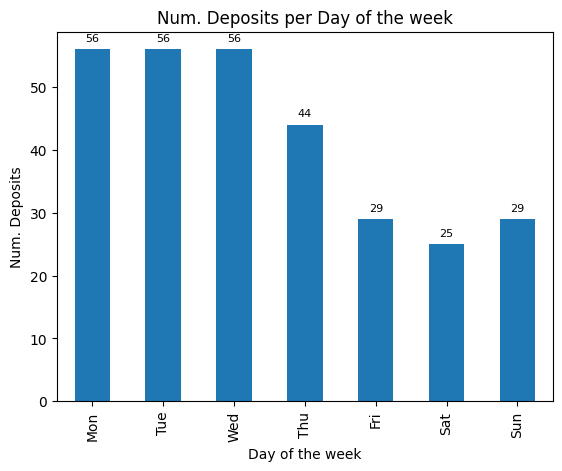

In [66]:
show_bar_plot("count_deposit_x_dow")

<Figure size 1500x600 with 0 Axes>

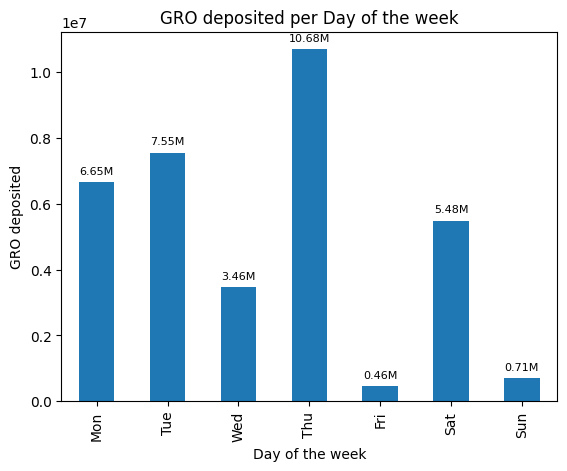

In [67]:
show_bar_plot("sum_gro_x_dow")

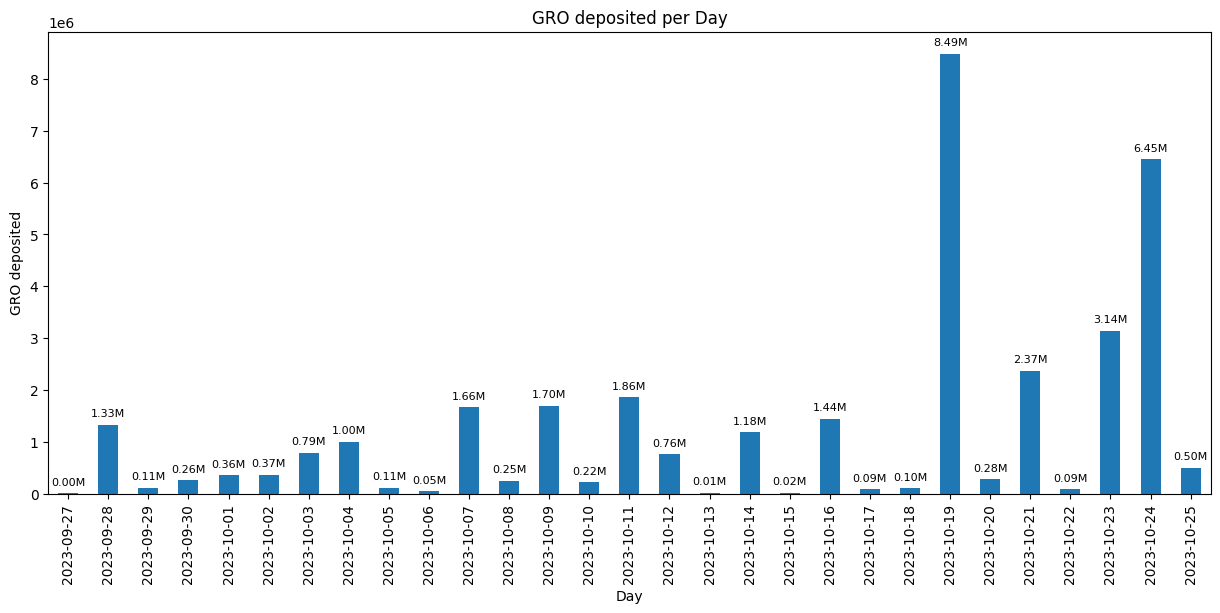

In [68]:
show_bar_plot('sum_gro_x_day')

In [69]:
from datetime import datetime, timedelta


REDEMPTION_TARGET_DATE = 1698251639  # 25 October 2023 16:33:59
end_datetime = datetime.utcfromtimestamp(REDEMPTION_TARGET_DATE)
# end_datetime = datetime(2023, 10, 25, 16, 33, 59) # without unix ts
start_datetime = end_datetime - timedelta(days=7)

df_txns_last_week = df_txns[
    (df_txns["DateTime (UTC)"] >= start_datetime)
    & (df_txns["DateTime (UTC)"] < end_datetime)
]

gro = df_txns["TokenValue"].sum()
gro_last_week = df_txns_last_week["TokenValue"].sum()
gro_last_week_pct = (gro_last_week / gro) * 100

print(f'{"GRO deposited:":<27} {gro:,.2f}')
print(f'{"GRO deposited last week:":<27} {gro_last_week:,.2f} ({gro_last_week_pct:.2f}%)')

GRO deposited:              34,983,431.88
GRO deposited last week:    21,382,274.86 (61.12%)
